In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/"

/content/drive/My Drive


In [4]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Cell_Phones_and_Accessories_5.json.gz')

In [5]:
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      3519
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [6]:
sum(df.overall) / len(df.overall)

4.129912208970422

In [ ]:
df.head(5)

## NLTK FOR NLP and analysis

In [8]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
df['reviewText'] = df['reviewText'].str.lower()

## Tokenization

In [10]:
def identify_tokens(row):
    review = row['reviewText']
    tokens = word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['words'] = df.apply(identify_tokens, axis=1)

## Stemming


In [12]:
def stem_list(row):
    my_list = row['words']
    stemmed_list = [stemmer.stem(word) for word in my_list]
    return (stemmed_list)

df['stemmed_words'] = df.apply(stem_list, axis=1)

## Removing stop words


In [13]:
stops = set(stopwords.words("english"))

def remove_stops(row):
    my_list = row['stemmed_words']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

df['stem_meaningful'] = df.apply(remove_stops, axis=1)


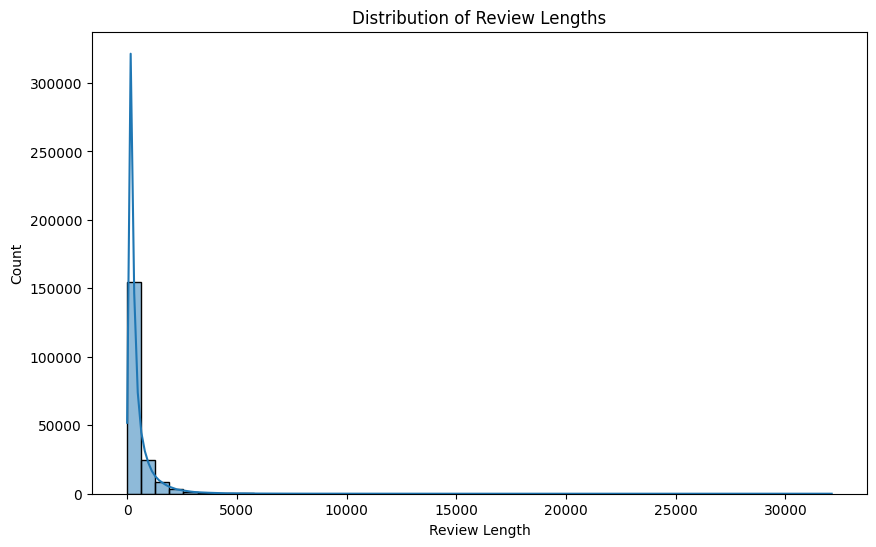

In [32]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from collections import Counter

# Visualization of Review Lengths
df['review_length'] = df['reviewText'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()



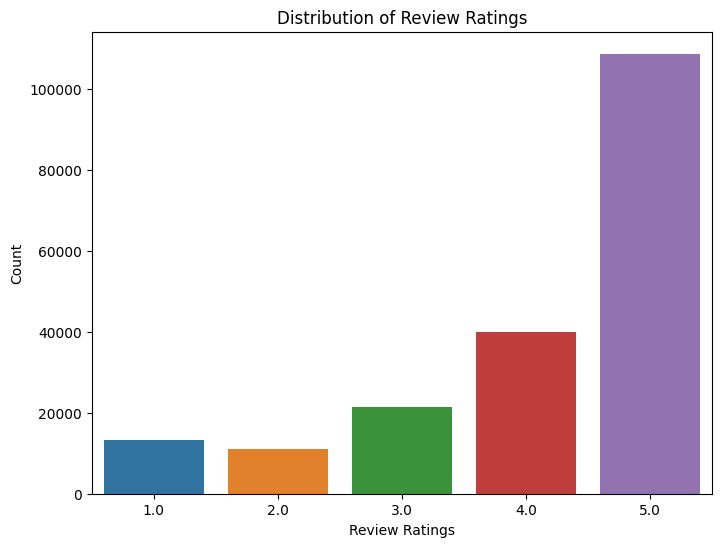

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Visualization of Review Ratings Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='overall', data=df)
plt.title('Distribution of Review Ratings')
plt.xlabel('Review Ratings')
plt.ylabel('Count')
plt.show()

In [14]:
def rejoin_words(row):
    my_list = row['stem_meaningful']
    joined_words = ( " ".join(my_list))
    return joined_words

df['processed'] = df.apply(rejoin_words, axis=1)

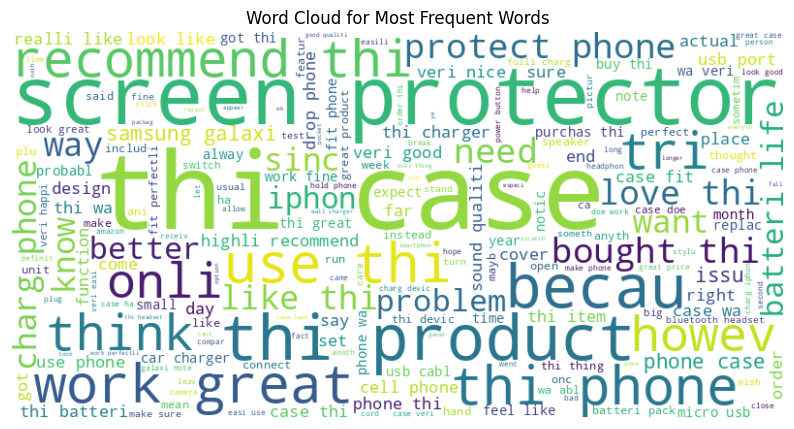

In [33]:
# Word Cloud for Most Frequent Words
wordcloud = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white', width=800, height=400).generate(' '.join(df['processed']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Most Frequent Words')
plt.show()



In [15]:
review_list = df['processed'].loc[0:14999].to_numpy()

In [16]:
len(review_list)

15000

In [18]:
review_labels = df['overall'].loc[0:14999].to_numpy()
review_labels

array([4., 5., 5., ..., 5., 1., 2.])

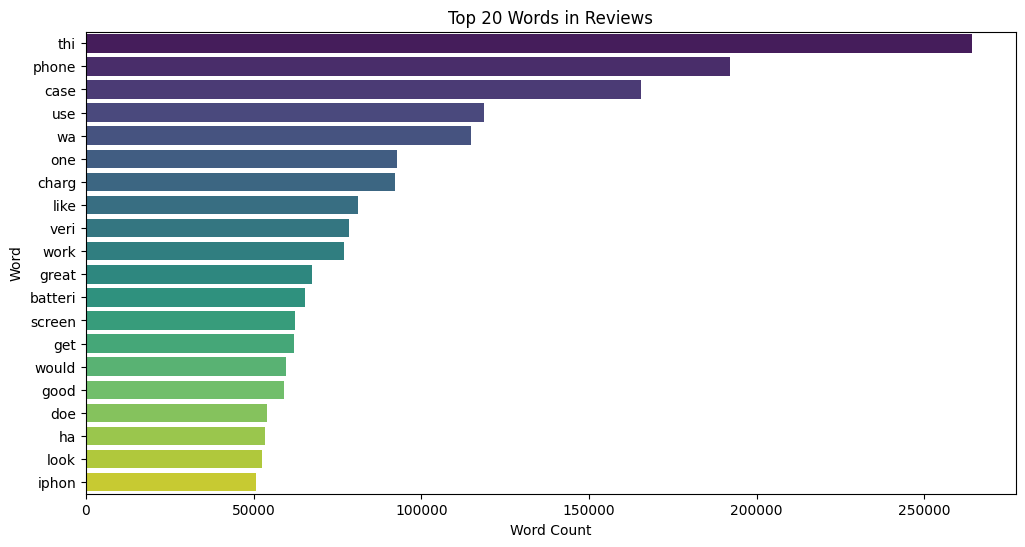

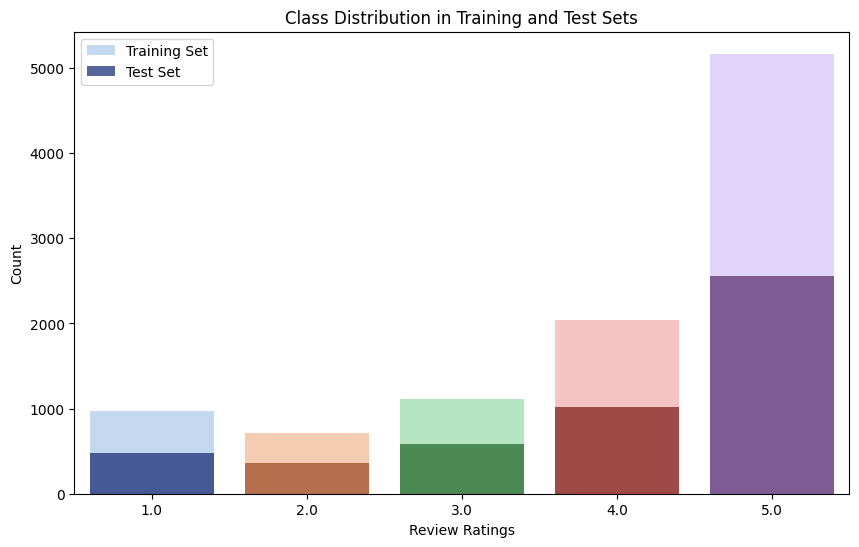

In [34]:
# Bar Chart for Top N Words
top_words = Counter(' '.join(df['processed']).split()).most_common(20)
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=top_words_df, palette='viridis')
plt.title('Top 20 Words in Reviews')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.show()

# Class Distribution in Training and Test Sets
plt.figure(figsize=(10, 6))
sns.countplot(x=train_labels, palette='pastel', label='Training Set', alpha=0.7)
sns.countplot(x=test_labels, palette='dark', label='Test Set', alpha=0.7)
plt.title('Class Distribution in Training and Test Sets')
plt.xlabel('Review Ratings')
plt.ylabel('Count')
plt.legend()
plt.show()


## Model Creation

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [20]:
def split_vals(a,n):
  return a[:n].copy(), a[n:].copy()

n_valid = 5000  # same as Kaggle's test set size
n_trn = 15000 - n_valid
# raw_train, raw_valid = split_vals(df_raw, n_trn)
train_data, test_data = split_vals(review_list, n_trn)
train_labels, test_labels = split_vals(review_labels, n_trn)

train_data.shape, train_labels.shape, test_data.shape


counter = CountVectorizer()
counter.fit(train_data)


CountVectorizer()

In [ ]:
counter.vocabulary_


In [22]:
len(counter.vocabulary_)

12327

In [23]:
training_counts = counter.transform(train_data)
test_counts = counter.transform(test_data)
training_counts.toarray()

test_counts.shape


(5000, 12327)

## Confusion mtrix

In [ ]:
classifier = MultinomialNB()
classifier.fit(training_counts, train_labels)
# print(classifier.predict(test_counts))
print(classifier.predict_proba(test_counts))

In [25]:
print(classifier.score(test_counts, test_labels))

0.5538


<Figure size 800x800 with 0 Axes>

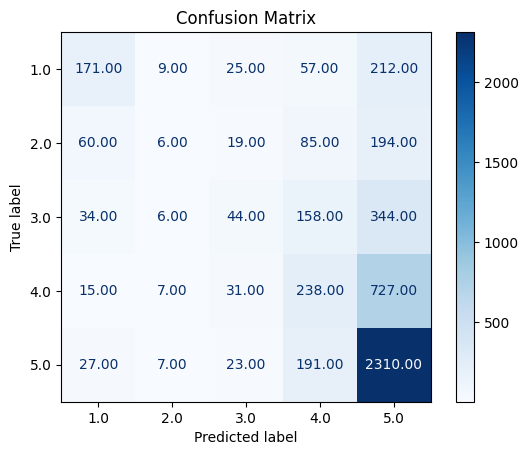

In [30]:
predictions = classifier.predict(test_counts)
cm = confusion_matrix(test_labels, predictions)

# Visualization of Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='.2f')
plt.title('Confusion Matrix')
plt.show()

# SVM

SVM Accuracy: 0.5186

Classification Report:
               precision    recall  f1-score   support

         1.0       0.40      0.48      0.43       474
         2.0       0.19      0.20      0.19       364
         3.0       0.24      0.24      0.24       586
         4.0       0.35      0.26      0.30      1018
         5.0       0.70      0.74      0.72      2558

    accuracy                           0.52      5000
   macro avg       0.37      0.38      0.38      5000
weighted avg       0.51      0.52      0.51      5000



<Figure size 800x800 with 0 Axes>

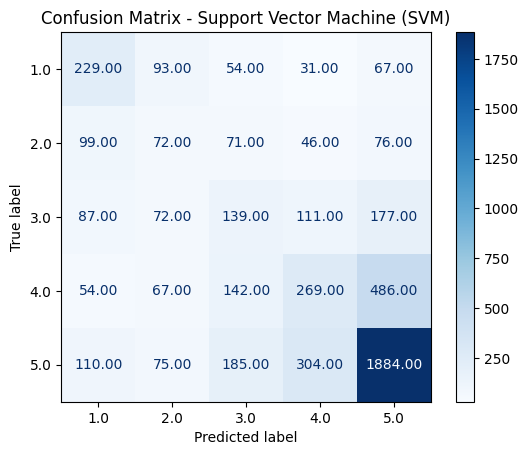

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report

classifier_svm = SVC(kernel='linear', probability=True)  # probability=True for probability estimates
classifier_svm.fit(training_counts, train_labels)

# Predictions
predictions_svm = classifier_svm.predict(test_counts)

# Accuracy and Classification Report
accuracy_svm = accuracy_score(test_labels, predictions_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}\n')

# Classification Report
print("Classification Report:\n", classification_report(test_labels, predictions_svm))

# Confusion Matrix
cm_svm = confusion_matrix(test_labels, predictions_svm)

# Visualization of Confusion Matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=classifier_svm.classes_)
plt.figure(figsize=(8, 8))
disp_svm.plot(cmap='Blues', values_format='.2f')
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.show()
